In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
from highlight_text import ax_text, fig_text
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap

from highlight_text import ax_text
from PIL import Image
from mplsoccer import add_image
import matplotlib.ticker as ticker
import urllib
from urllib.request import urlopen

from sklearn.cluster import KMeans
import matplotlib.patches as patches

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("D:\FData\LaLiga_2023-24\GW1_to_GW_38combinded.csv")

In [2]:
df = pd.read_csv("D:\FData\EPL_2023-24\EPL_2023\EPL_2023_2024GW01_to_GW38.csv")

# For

In [3]:
def plot_blank(ax):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='#f5f5f5', spot_type='square', linewidth=2, half=True, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(52.35)
    ax.set_xlim(-0.5, 68.5)

C:\Users\h\AppData\Local\Temp\ipykernel_1064\2608275849.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type1'] = df_team['type'].shift(-1)
C:\Users\h\AppData\Local\Temp\ipykernel_1064\2608275849.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type2'] = df_team['type'].shift(-2)
C:\Users\h\AppData\Local\Temp\ipykernel_1064\2608275849.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

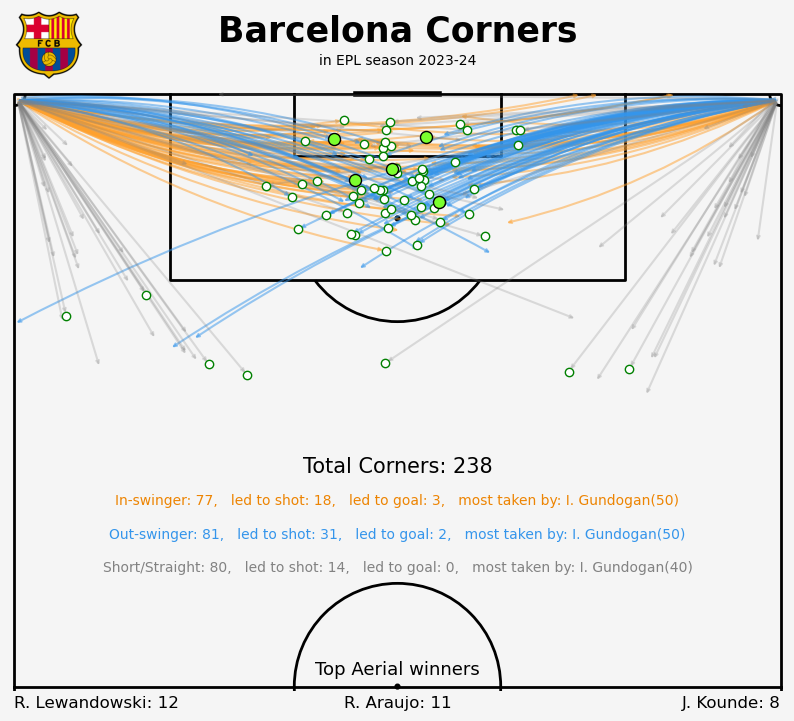

In [3]:
def plot_corners(ax, team_name):
    df_team = df[(df['teamName']==team_name) | (df['oppositionTeamName']==team_name)]
    df_corners = df_team[(df_team['teamName']==team_name) & (df_team['type']=='Pass') & (df_team['qualifiers'].str.contains('CornerTaken'))]

    # Inswingers & Outswingers
    inswinger_left = df_corners[(df_corners['y']>=65) & (df_corners['qualifiers'].str.contains('RightFoot'))]
    outswinger_left = df_corners[(df_corners['y']>=65) & (df_corners['qualifiers'].str.contains('LeftFoot'))]
    inswinger_right = df_corners[(df_corners['y']<=3) & (df_corners['qualifiers'].str.contains('LeftFoot'))]
    outswinger_right = df_corners[(df_corners['y']<=3) & (df_corners['qualifiers'].str.contains('RightFoot'))]
    # Short Corners & Others
    short_c = df_corners[(~df_corners['qualifiers'].str.contains('RightFoot')) & (~df_corners['qualifiers'].str.contains('LeftFoot'))]
    left_shortc = short_c[short_c['y']>=65]
    right_shortc = short_c[short_c['y']<=3]
    
    df_ins = pd.concat([inswinger_left, inswinger_right], axis=0, ignore_index=True)
    df_ots = pd.concat([outswinger_left, outswinger_right], axis=0, ignore_index=True)
    
    most_ins = df_ins['shortName'].value_counts()
    most_ins_pname = most_ins.idxmax()
    most_ins_count = most_ins.max()
    most_ots = df_ots['shortName'].value_counts()
    most_ots_pname = most_ots.idxmax()
    most_ots_count = most_ots.max()
    most_shc = short_c['shortName'].value_counts()
    most_shc_pname = most_shc.idxmax()
    most_shc_count = most_shc.max()

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax) 
    ax.set_ylim(52.15)
    ax.set_xlim(-0.35, 68.35)

    for _, row in inswinger_left.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#ffa12e', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=0.10')
        ax.add_patch(arrow)
    for _, row in inswinger_right.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#ffa12e', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=-0.10')
        ax.add_patch(arrow)

    for _, row in outswinger_left.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#3495eb', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=-0.10')
        ax.add_patch(arrow)
    for _, row in outswinger_right.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#3495eb', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=0.10')
        ax.add_patch(arrow)

    for _, row in short_c.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#828282', zorder=2, mutation_scale=5, alpha=0.25, linewidth=1.5, connectionstyle='arc3,rad=0')
        ax.add_patch(arrow)

    in_led_to_shot = 0
    ot_led_to_shot = 0
    sh_led_to_shot = 0
    
    in_led_to_goal = 0
    ot_led_to_goal = 0
    sh_led_to_goal = 0
    
    df_team['next_type1'] = df_team['type'].shift(-1)
    df_team['next_type2'] = df_team['type'].shift(-2)
    df_team['next_type3'] = df_team['type'].shift(-3)
    
    for _, row in df_team.iterrows():
        # inswinger outcomes
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            ((('RightFoot' in row['qualifiers']) and (row['y']>65)) or (('LeftFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Shot' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Shot' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Shot' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='w', edgecolor='g', zorder=4)
            in_led_to_shot += 1 
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            ((('RightFoot' in row['qualifiers']) and (row['y']>65)) or (('LeftFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Goal' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Goal' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Goal' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='#7bff2e', edgecolor='k', s=75, zorder=5)
            in_led_to_goal += 1
            
        # outswinger outcomes
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            ((('LeftFoot' in row['qualifiers']) and (row['y']>65)) or (('RightFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Shot' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Shot' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Shot' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='w', edgecolor='g', zorder=4)
            ot_led_to_shot += 1 
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            ((('LeftFoot' in row['qualifiers']) and (row['y']>65)) or (('RightFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Goal' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Goal' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Goal' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='#7bff2e', edgecolor='k', s=75, zorder=5)
            ot_led_to_goal += 1

        # short_c outcomes
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            ((('LeftFoot' not in row['qualifiers'])) and (('RightFoot' not in row['qualifiers']))) and
            (('Shot' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Shot' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Shot' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='w', edgecolor='g', zorder=4)
            sh_led_to_shot += 1 
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            ((('LeftFoot' not in row['qualifiers'])) and (('RightFoot' not in row['qualifiers']))) and
            (('Goal' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Goal' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Goal' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='#7bff2e', edgecolor='k', s=75, zorder=5)
            sh_led_to_goal += 1

    next_player_names = []

    # Iterate through the DataFrame
    df_team['next_player'] = df_team['shortName'].shift(-1)
    for _, row in df_team.iterrows():
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['teamName']==team_name) and 
            (row['outcomeType']=='Successful') and
            (row['prog_pass']>=13)
        ):
            next_player_names.append(row['next_player'])
        
    player_count = Counter(next_player_names)
    top_3_players = player_count.most_common(3)
    ax.text(34, 54, "Top Aerial winners", fontsize=13, ha='center', va='center')
    
    if len(top_3_players) > 0:
        player, count = top_3_players[0]
        ax.text(68, 51, f"{player}: {count}", ha='left', va='center', fontsize=12)
    if len(top_3_players) > 1:
        player, count = top_3_players[1]
        ax.text(34, 51, f"{player}: {count}", ha='center', va='center', fontsize=12)
    if len(top_3_players) > 2:
        player, count = top_3_players[2]
        ax.text(0, 51, f"{player}: {count}", ha='right', va='center', fontsize=12)

    ax.text(34, 72, f'Total Corners: {len(df_corners)}', fontsize=15, ha='center', va='center')
    ax.text(34, 69, f'In-swinger: {len(inswinger_left)+len(inswinger_right)},   led to shot: {in_led_to_shot},   led to goal: {in_led_to_goal},   most taken by: {most_ins_pname}({most_ins_count})',
            fontsize=10, color='#ed8402', ha='center', va='center')
    ax.text(34, 66, f'Out-swinger: {len(outswinger_left)+len(outswinger_right)},   led to shot: {ot_led_to_shot},   led to goal: {ot_led_to_goal},   most taken by: {most_ots_pname}({most_ots_count})',
            fontsize=10, color='#3495eb', ha='center', va='center')
    ax.text(34, 63, f'Short/Straight: {len(short_c)},   led to shot: {sh_led_to_shot},   led to goal: {sh_led_to_goal},   most taken by: {most_shc_pname}({most_shc_count})',
            fontsize=10, color='#828282', ha='center', va='center')
    
    # # Take data coordinates and transform them to normalized figure coordinates
    # DC_to_FC = ax.transData.transform
    # FC_to_NFC = fig.transFigure.inverted().transform
    # DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    # ax_coords = DC_to_NFC((-1.5,107))
    # ax_size = 0.023
    # image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    # fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    # fotmob_url = fotmob_url.replace(' ', '%20')
    # club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    # image_ax.imshow(club_icon)
    # image_ax.axis('off')
    # ax.invert_xaxis()
    # ax.set_title(f'{team_name} Corners', fontsize=25, fontweight='bold')
    
    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((0,102))
    ax_size = 0.07
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    ax.invert_xaxis()
    ax.set_title(f'{team_name} Corners', fontsize=25, fontweight='bold')
    ax.text(34, 108, 'in EPL season 2023-24', ha='center', va='center')

    return 

fig,ax=plt.subplots(figsize=(10,10), facecolor='#f5f5f5')
plot_corners(ax, 'Barcelona')

In [10]:
df_team = df[(df['teamName']=='Liverpool') | (df['oppositionTeamName']=='Liverpool')]
df_corners = df_team[(df_team['teamName']=='Liverpool') & (df_team['type']=='Pass') & (df_team['qualifiers'].str.contains('CornerTaken'))]

# Inswingers & Outswingers
inswinger_left = df_corners[(df_corners['y']>=65) & (df_corners['qualifiers'].str.contains('RightFoot'))]
outswinger_left = df_corners[(df_corners['y']>=65) & (df_corners['qualifiers'].str.contains('LeftFoot'))]
inswinger_right = df_corners[(df_corners['y']<=3) & (df_corners['qualifiers'].str.contains('LeftFoot'))]
outswinger_right = df_corners[(df_corners['y']<=3) & (df_corners['qualifiers'].str.contains('RightFoot'))]
# Short Corners & Others
short_c = df_corners[(~df_corners['qualifiers'].str.contains('RightFoot')) & (~df_corners['qualifiers'].str.contains('LeftFoot'))]
left_shortc = short_c[short_c['y']>=65]
right_shortc = short_c[short_c['y']<=3]

df_ins = pd.concat([inswinger_left, inswinger_right], axis=0, ignore_index=True)
df_ots = pd.concat([outswinger_left, outswinger_right], axis=0, ignore_index=True)

In [12]:
short_c.to_csv(r"D:\FData\EPL_2023-24\EPL_2023\test.csv")

In [ ]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#f5f5f5', dpi=150)
axs = axs.flatten()

# List of team names
team_names = ['Real Madrid', 'Barcelona', 'Girona', 'Atletico', 'Athletic Club', 'Real Sociedad', 'Real Betis', 'Villarreal']

for i, team_name in enumerate(team_names):
    plot_corners(axs[i], team_name)

plot_blank(axs[8])
plot_corners(axs[9], 'Valencia')
plot_corners(axs[10], 'Deportivo Alaves')
plot_blank(axs[11])

fig.text(0.19, 0.97, 'LaLiga Teams Corners Analysis (Part-1)', color='#ff4b44', fontweight='bold', fontsize=45, ha='left', va='center')
fig.text(0.19, 0.945, 'Top 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', 
         color='#505050', fontsize=25, ha='left', va='center')

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.92, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")

In [ ]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#f5f5f5', dpi=150)
axs = axs.flatten()

# List of team names
team_names = ['Osasuna', 'Getafe', 'Celta Vigo', 'Sevilla', 'Mallorca', 'Las Palmas', 
              'Rayo Vallecano', 'Cadiz']

for i, team_name in enumerate(team_names):
    plot_corners(axs[i], team_name)

plot_blank(axs[8])
plot_corners(axs[9], 'Almeria')
plot_corners(axs[10], 'Granada')
plot_blank(axs[11])

fig.text(0.19, 0.97, 'LaLiga Teams Corners Analysis (Part-2)', color='#ff4b44', fontweight='bold', fontsize=45, ha='left', va='center')
fig.text(0.19, 0.945, 'Bottom 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', 
         color='#505050', fontsize=25, ha='left', va='center')

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.92, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")

# Against

C:\Users\h\AppData\Local\Temp\ipykernel_15448\2140123482.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type1'] = df_team['type'].shift(-1)
C:\Users\h\AppData\Local\Temp\ipykernel_15448\2140123482.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type2'] = df_team['type'].shift(-2)
C:\Users\h\AppData\Local\Temp\ipykernel_15448\2140123482.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

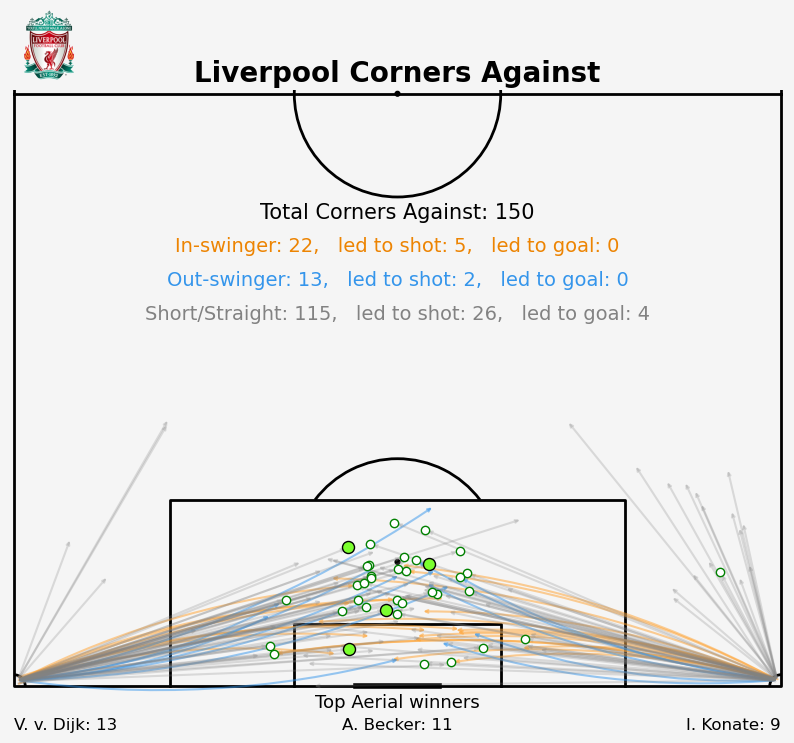

In [5]:
def plot_corners_against(ax, team_name):
    df_team = df[(df['teamName']==team_name) | (df['oppositionTeamName']==team_name)]
    df_corners = df[(df['oppositionTeamName']==team_name) & (df['type']=='Pass') & (df['qualifiers'].str.contains('CornerTaken'))]

    # Inswingers & Outswingers
    inswinger_left = df_corners[(df_corners['y']>=65) & (df_corners['qualifiers'].str.contains('RightFoot'))]
    outswinger_left = df_corners[(df_corners['y']>=65) & (df_corners['qualifiers'].str.contains('LeftFoot'))]
    inswinger_right = df_corners[(df_corners['y']<=3) & (df_corners['qualifiers'].str.contains('LeftFoot'))]
    outswinger_right = df_corners[(df_corners['y']<=3) & (df_corners['qualifiers'].str.contains('RightFoot'))]
    # Short Corners & Others
    short_c = df_corners[(~df_corners['qualifiers'].str.contains('RightFoot')) & (~df_corners['qualifiers'].str.contains('LeftFoot'))]
    left_shortc = short_c[short_c['y']>=65]
    right_shortc = short_c[short_c['y']<=3]
    

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax) 
    ax.set_ylim(52.15)
    ax.set_xlim(-0.35, 68.35)

    for _, row in inswinger_left.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#ffa12e', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=0.10')
        ax.add_patch(arrow)
    for _, row in inswinger_right.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#ffa12e', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=-0.10')
        ax.add_patch(arrow)

    for _, row in outswinger_left.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#3495eb', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=-0.10')
        ax.add_patch(arrow)
    for _, row in outswinger_right.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#3495eb', zorder=2, mutation_scale=5, alpha=0.5, linewidth=1.5, connectionstyle='arc3,rad=0.10')
        ax.add_patch(arrow)

    for _, row in short_c.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->',
                                        color='#828282', zorder=2, mutation_scale=5, alpha=0.25, linewidth=1.5, connectionstyle='arc3,rad=0')
        ax.add_patch(arrow)

    in_led_to_shot = 0
    ot_led_to_shot = 0
    sh_led_to_shot = 0
    
    in_led_to_goal = 0
    ot_led_to_goal = 0
    sh_led_to_goal = 0
    
    df_team['next_type1'] = df_team['type'].shift(-1)
    df_team['next_type2'] = df_team['type'].shift(-2)
    df_team['next_type3'] = df_team['type'].shift(-3)
    
    for _, row in df_team.iterrows():
        # inswinger outcomes
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            ((('RightFoot' in row['qualifiers']) and (row['y']>65)) or (('LeftFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Shot' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Shot' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Shot' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='w', edgecolor='g', zorder=4)
            in_led_to_shot += 1 
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            ((('RightFoot' in row['qualifiers']) and (row['y']>65)) or (('LeftFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Goal' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Goal' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Goal' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='#7bff2e', edgecolor='k', s=75, zorder=5)
            in_led_to_goal += 1
            
        # outswinger outcomes
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            ((('LeftFoot' in row['qualifiers']) and (row['y']>65)) or (('RightFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Shot' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Shot' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Shot' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='w', edgecolor='g', zorder=4)
            ot_led_to_shot += 1 
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            ((('LeftFoot' in row['qualifiers']) and (row['y']>65)) or (('RightFoot' in row['qualifiers']) and (row['y']<3))) and
            (('Goal' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Goal' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Goal' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='#7bff2e', edgecolor='k', s=75, zorder=5)
            ot_led_to_goal += 1

        # short_c outcomes
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            ((('LeftFoot' not in row['qualifiers'])) and (('RightFoot' not in row['qualifiers']))) and
            (('Shot' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Shot' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Shot' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='w', edgecolor='g', zorder=4)
            sh_led_to_shot += 1 
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            ((('LeftFoot' not in row['qualifiers'])) and (('RightFoot' not in row['qualifiers']))) and
            (('Goal' in row['next_type1'] if row['next_type1'] is not None else False) or
             ('Goal' in row['next_type2'] if row['next_type2'] is not None else False) or
             ('Goal' in row['next_type3'] if row['next_type3'] is not None else False)
            )
        ):
            ax.scatter(row['endY'], row['endX'], color='#7bff2e', edgecolor='k', s=75, zorder=5)
            sh_led_to_goal += 1

    next_player_names = []

    # Iterate through the DataFrame
    df_team['next_player'] = df_team['shortName'].shift(-1)
    for _, row in df_team.iterrows():
        if (
            ('CornerTaken' in row['qualifiers']) and 
            (row['oppositionTeamName']==team_name) and 
            (row['outcomeType']=='Unsuccessful') and
            (row['prog_pass']>=13)
        ):
            next_player_names.append(row['next_player'])
        
    player_count = Counter(next_player_names)
    top_3_players = player_count.most_common(3)
    ax.text(34, 106.5, "Top Aerial winners", fontsize=13, ha='center', va='center')
    
    if len(top_3_players) > 0:
        player, count = top_3_players[0]
        ax.text(0, 108.5, f"{player}: {count}", ha='left', va='center', fontsize=12)
    if len(top_3_players) > 1:
        player, count = top_3_players[1]
        ax.text(34, 108.5, f"{player}: {count}", ha='center', va='center', fontsize=12)
    if len(top_3_players) > 2:
        player, count = top_3_players[2]
        ax.text(68, 108.5, f"{player}: {count}", ha='right', va='center', fontsize=12)

    ax.text(34, 63, f'Total Corners Against: {len(df_corners)}', fontsize=15, ha='center', va='center')
    ax.text(34, 66, f'In-swinger: {len(inswinger_left)+len(inswinger_right)},   led to shot: {in_led_to_shot},   led to goal: {in_led_to_goal}',
            fontsize=14, color='#ed8402', ha='center', va='center')
    ax.text(34, 69, f'Out-swinger: {len(outswinger_left)+len(outswinger_right)},   led to shot: {ot_led_to_shot},   led to goal: {ot_led_to_goal}',
            fontsize=14, color='#3495eb', ha='center', va='center')
    ax.text(34, 72, f'Short/Straight: {len(short_c)},   led to shot: {sh_led_to_shot},   led to goal: {sh_led_to_goal}',
            fontsize=14, color='#828282', ha='center', va='center')
    
    # # Take data coordinates and transform them to normalized figure coordinates
    # DC_to_FC = ax.transData.transform
    # FC_to_NFC = fig.transFigure.inverted().transform
    # DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    # ax_coords = DC_to_NFC((-1.5,107))
    # ax_size = 0.023
    # image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    # fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    # fotmob_url = fotmob_url.replace(' ', '%20')
    # club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    # image_ax.imshow(club_icon)
    # image_ax.axis('off')
    # ax.invert_xaxis()
    # ax.set_title(f'{team_name} Corners', fontsize=25, fontweight='bold')
    
    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((0,105))
    ax_size = 0.07
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    ax.invert_yaxis()
    ax.set_title(f'{team_name} Corners Against', fontsize=20, fontweight='bold')

    return 

fig,ax=plt.subplots(figsize=(10,10), facecolor='#f5f5f5')
plot_corners_against(ax, 'Liverpool')

C:\Users\h\AppData\Local\Temp\ipykernel_9344\2819717961.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type1'] = df_team['type'].shift(-1)
C:\Users\h\AppData\Local\Temp\ipykernel_9344\2819717961.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type2'] = df_team['type'].shift(-2)
C:\Users\h\AppData\Local\Temp\ipykernel_9344\2819717961.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Execution Time: 51.05359148979187 seconds


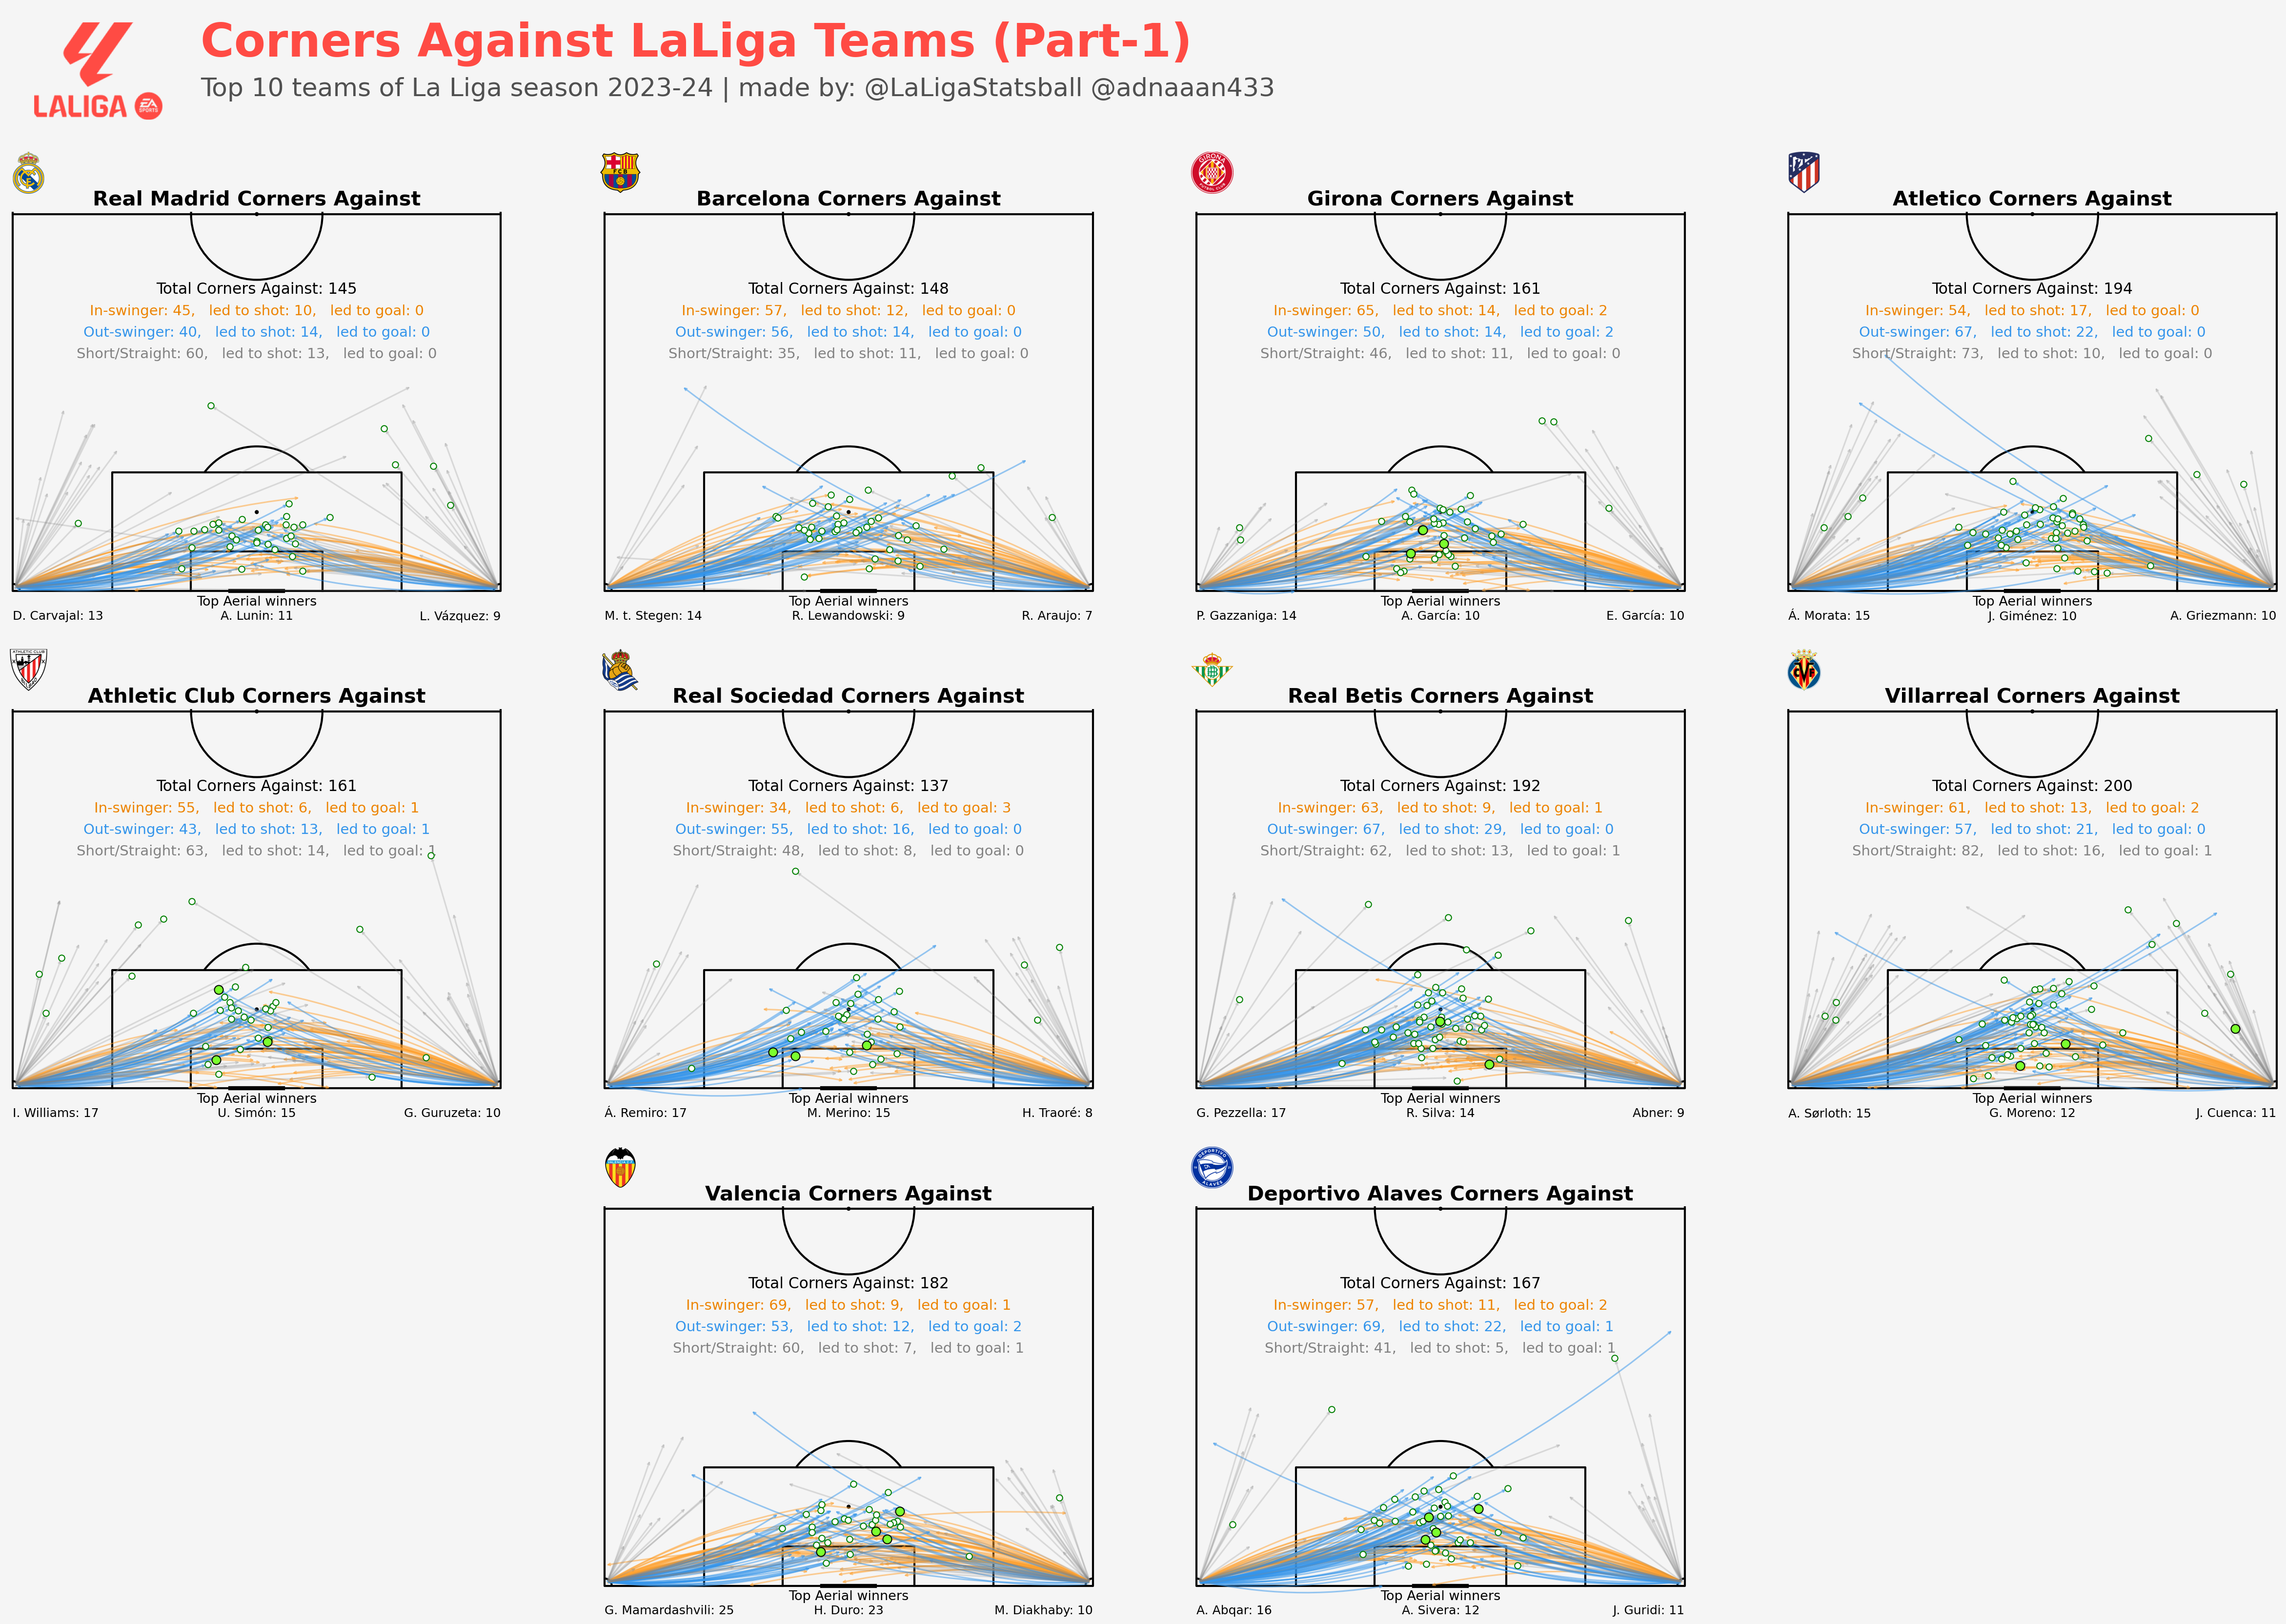

In [30]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#f5f5f5', dpi=150)
axs = axs.flatten()

# List of team names
team_names = ['Real Madrid', 'Barcelona', 'Girona', 'Atletico', 'Athletic Club', 'Real Sociedad', 'Real Betis', 'Villarreal']

for i, team_name in enumerate(team_names):
    plot_corners_against(axs[i], team_name)

plot_blank(axs[8])
plot_corners_against(axs[9], 'Valencia')
plot_corners_against(axs[10], 'Deportivo Alaves')
plot_blank(axs[11])

fig.text(0.19, 0.97, 'Corners Against LaLiga Teams (Part-1)', color='#ff4b44', fontweight='bold', fontsize=45, ha='left', va='center')
fig.text(0.19, 0.945, 'Top 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', 
         color='#505050', fontsize=25, ha='left', va='center')

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.92, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")

C:\Users\h\AppData\Local\Temp\ipykernel_9344\2819717961.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type1'] = df_team['type'].shift(-1)
C:\Users\h\AppData\Local\Temp\ipykernel_9344\2819717961.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team['next_type2'] = df_team['type'].shift(-2)
C:\Users\h\AppData\Local\Temp\ipykernel_9344\2819717961.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Execution Time: 50.11718153953552 seconds


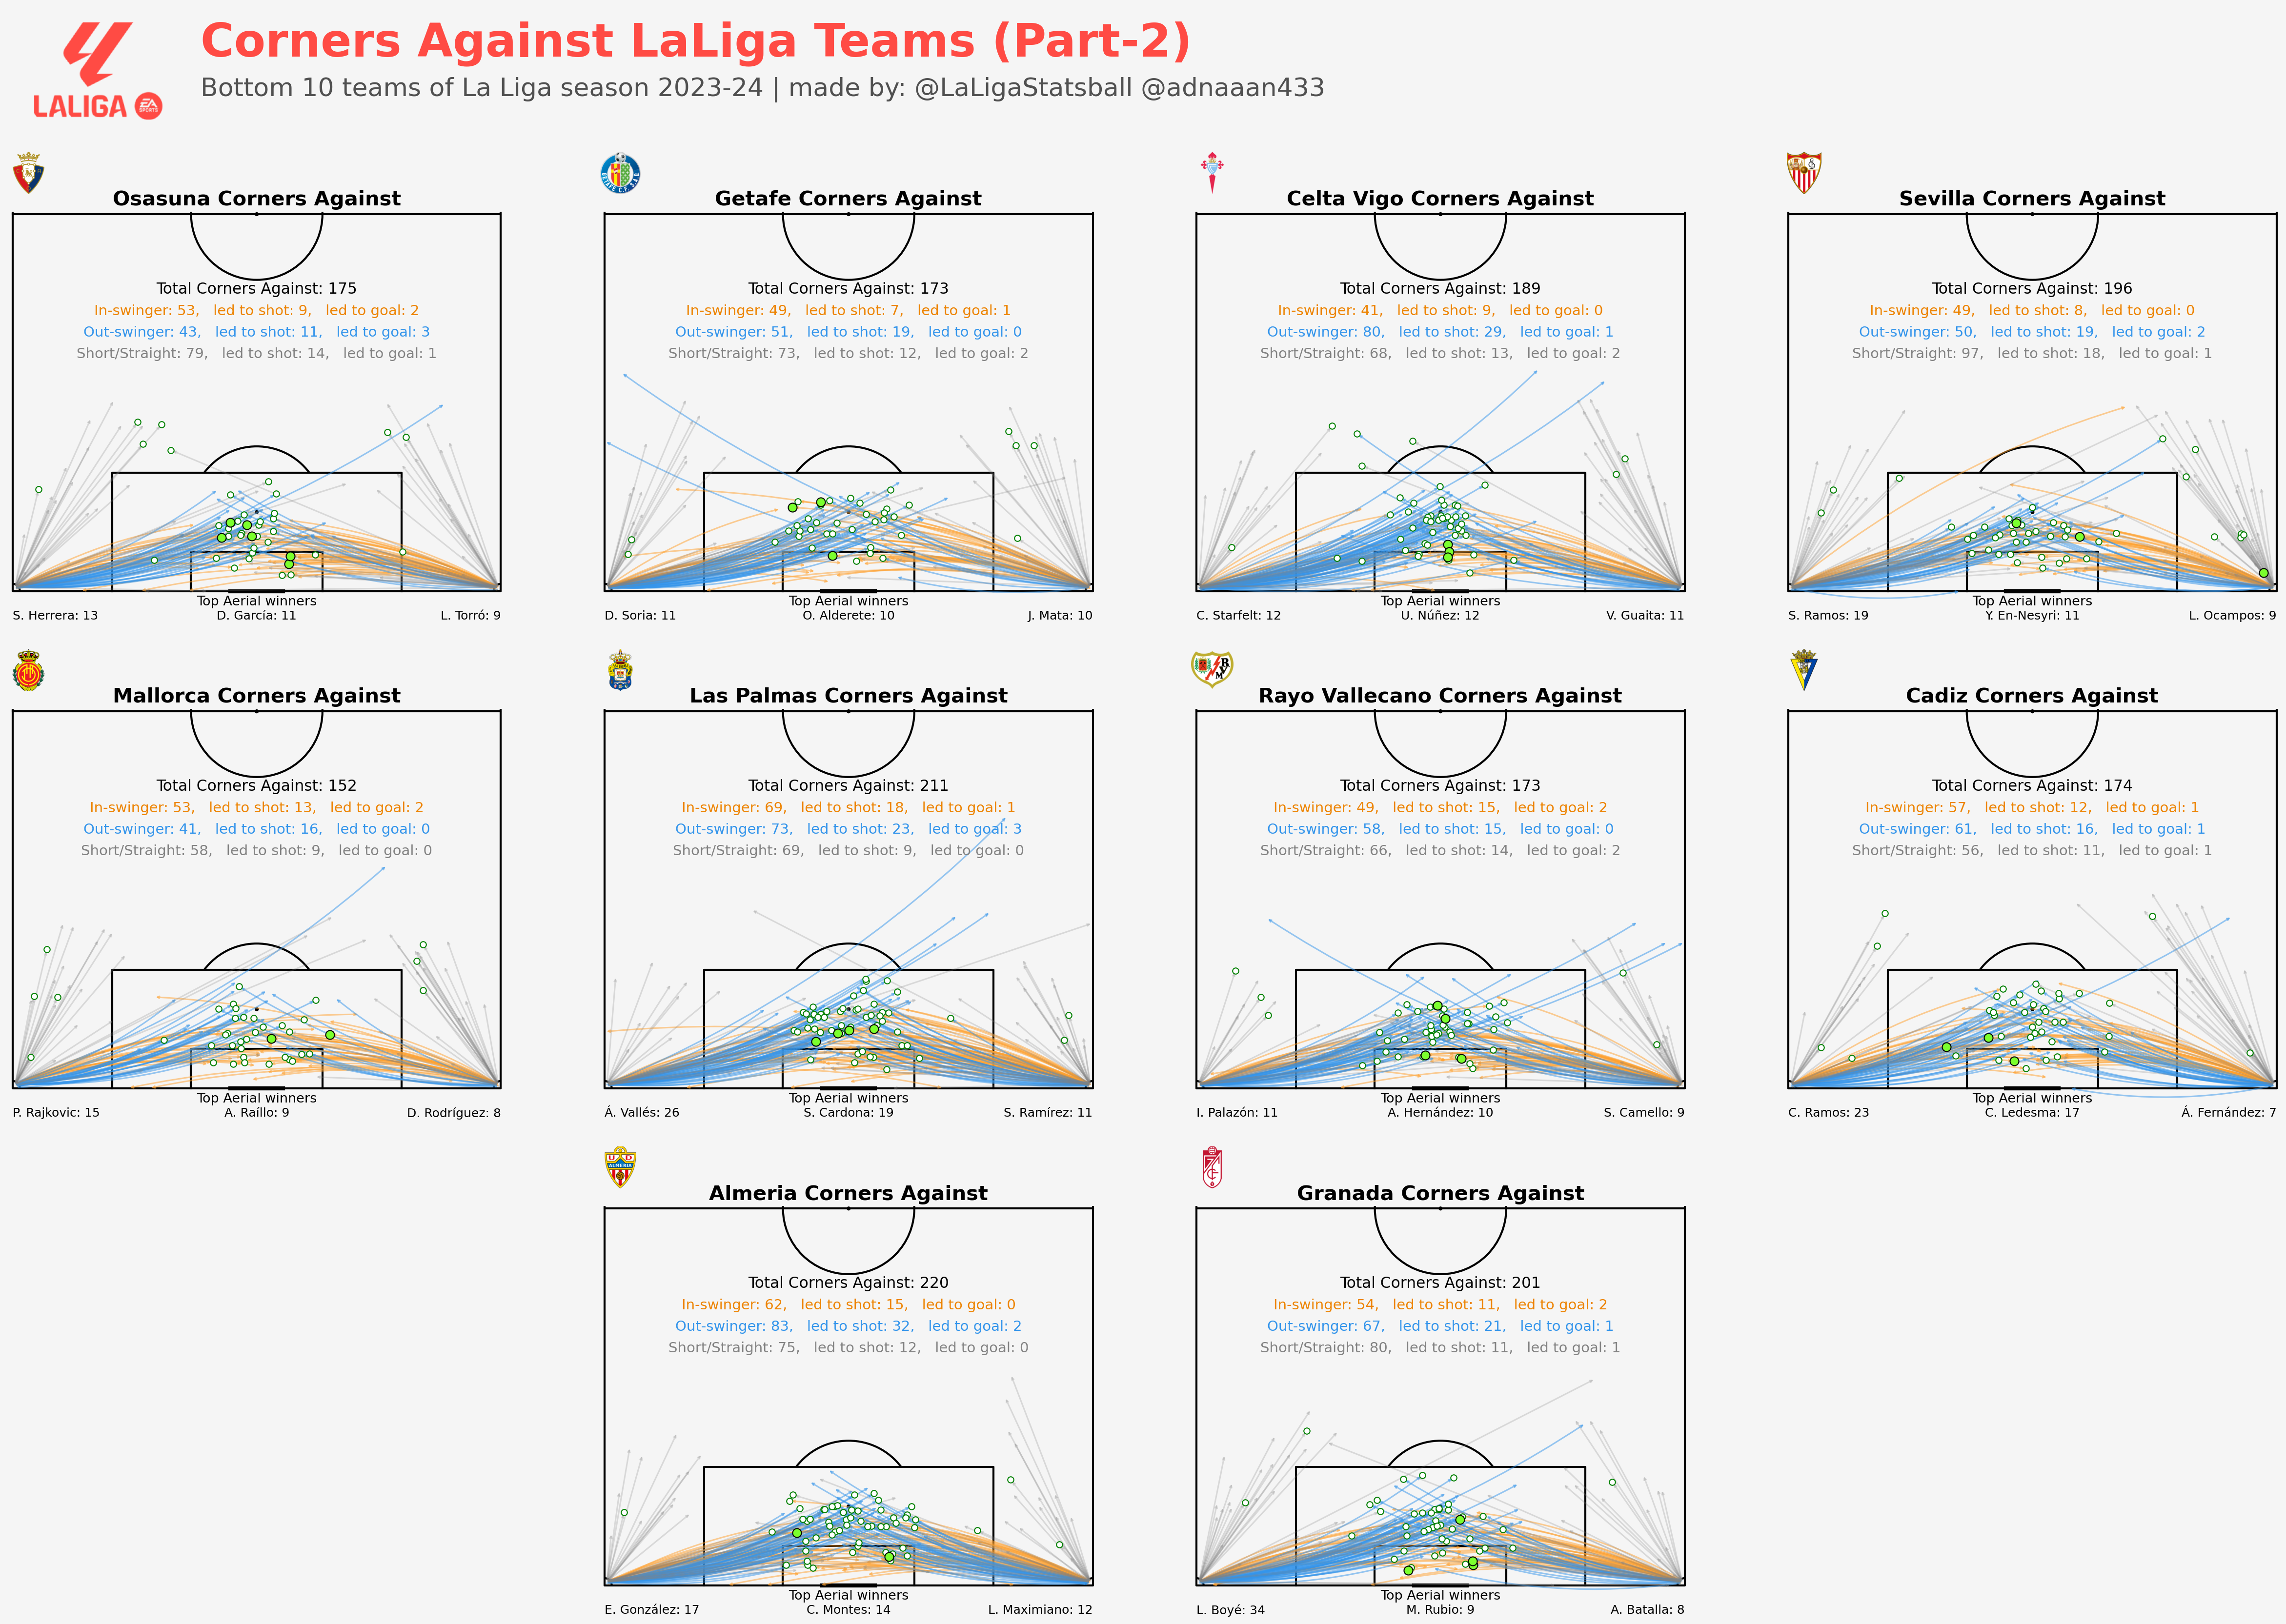

In [31]:
start_time = time.time()
fig, axs = plt.subplots(3, 4, figsize=(40, 25), facecolor='#f5f5f5', dpi=150)
axs = axs.flatten()

# List of team names
team_names = ['Osasuna', 'Getafe', 'Celta Vigo', 'Sevilla', 'Mallorca', 'Las Palmas', 
              'Rayo Vallecano', 'Cadiz']

for i, team_name in enumerate(team_names):
    plot_corners_against(axs[i], team_name)

plot_blank(axs[8])
plot_corners_against(axs[9], 'Almeria')
plot_corners_against(axs[10], 'Granada')
plot_blank(axs[11])

fig.text(0.19, 0.97, 'Corners Against LaLiga Teams (Part-2)', color='#ff4b44', fontweight='bold', fontsize=45, ha='left', va='center')
fig.text(0.19, 0.945, 'Bottom 10 teams of La Liga season 2023-24 | made by: @LaLigaStatsball @adnaaan433', 
         color='#505050', fontsize=25, ha='left', va='center')

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.12, bottom=0.92, width=0.07, height=0.07)



# plt.tight_layout()
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time} seconds")